In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
VITAL_API_BASE_URL = "https://api.vitaldb.net"
TRACKS_META_URL = f"{VITAL_API_BASE_URL}/trks"
CASE_INFO_URL = f"{VITAL_API_BASE_URL}/cases"

AGE_CASE_THRESHOLD = 18
CASEEND_CASE_THRESHOLD = 3600  # seconds
BLOOD_LOSS_THRESHOLD = 400  # mL
BOLUS_THRESHOLD = 20  # mg
FORBIDDEN_OPNAME_CASE = "transplant"
TRACK_NAME_MBP = "Solar8000/ART_MBP"
TRACK_NAME_BIS = "BIS/BIS"
STATIC_DATA_NAMES = ["age", "bmi", "asa", "preop_cr", "preop_htn", "opname"]

In [16]:
tracks_meta = pd.read_csv(TRACKS_META_URL, dtype={"tname": "category"})
cases = pd.read_csv(CASE_INFO_URL)

print(f"Initial number of cases: {len(cases)}")

cases_with_mbp = pd.merge(
    tracks_meta.query(f"tname == '{TRACK_NAME_MBP}'"),
    cases,
    on="caseid",
)

cases_with_bis = pd.merge(
    tracks_meta.query(f"tname == '{TRACK_NAME_BIS}'"),
    cases,
    on="caseid",
)

print(f"Number of cases with BIS: {len(cases_with_bis)}")

print(f"Number of cases with MBP: {len(cases_with_mbp)}")

cases_with_bis_and_mbp = cases_with_mbp[cases_with_mbp.caseid.isin(cases_with_bis.caseid.unique())]

print(f"Number of cases with both BIS and MBP: {len(cases_with_bis_and_mbp)}")
cases_with_mbp = cases_with_bis_and_mbp 
# The cases should met these requirements
filtered_unique_case_ids = cases_with_mbp[
    (cases_with_mbp.age > AGE_CASE_THRESHOLD)
    & (cases_with_mbp.caseend > CASEEND_CASE_THRESHOLD)
    & (~cases_with_mbp.opname.str.contains(FORBIDDEN_OPNAME_CASE, case=False))
    & (~cases_with_mbp.optype.str.contains(FORBIDDEN_OPNAME_CASE, case=False))
    # & (cases_with_mbp.intraop_eph <= BOLUS_THRESHOLD)
    # & (cases_with_mbp.intraop_phe <= BOLUS_THRESHOLD)
    # & (cases_with_mbp.intraop_epi <= BOLUS_THRESHOLD)
    # & (cases_with_mbp.intraop_mdz <= BOLUS_THRESHOLD)
    & (cases_with_mbp.emop == 0)
    & (
        (cases_with_mbp.intraop_ebl < BLOOD_LOSS_THRESHOLD)
        | (cases_with_mbp.intraop_ebl.isna())
    )
].caseid.unique()

print(f"Number of cases after filtering: {len(filtered_unique_case_ids)}")

# The cases should have the needed static data
potential_cases = cases[cases.caseid.isin(filtered_unique_case_ids)]
filtered_case_ids = potential_cases[
    potential_cases[STATIC_DATA_NAMES + ["caseid"]].isna().sum("columns") == 0
].caseid.tolist()

print(f"Number of cases after filtering static data: {len(filtered_case_ids)}")

Initial number of cases: 6388
Number of cases with BIS: 5867
Number of cases with MBP: 3724
Number of cases with both BIS and MBP: 3443
Number of cases after filtering: 1481
Number of cases after filtering static data: 1361


In [4]:
cases_with_given_signal = pd.merge(
    tracks_meta.query(f"tname == '{"Orchestra/NEPI_RATE"}'"),
    potential_cases,
    on="caseid",
)
print(f"Number of cases with signal: {len(cases_with_given_signal)}")
cases_with_given_signal.caseid

Number of cases with signal: 3


0    1537
1    3470
2    5703
Name: caseid, dtype: int64

<AxesSubplot:>

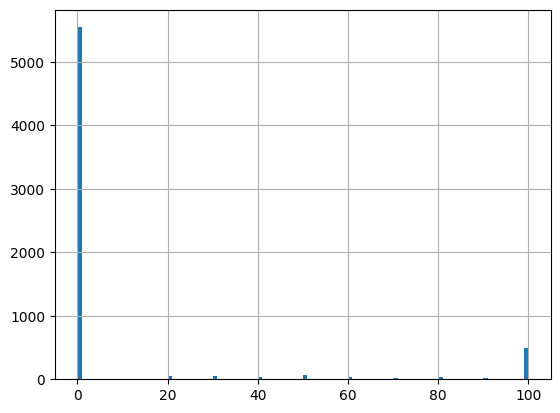

In [5]:
cases.intraop_phe.clip(upper=100).hist(bins=100)

In [6]:
case_data = pd.read_parquet("./data/cases/case-5703.parquet")

/tmp/ipykernel_228984/3800567265.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  case_data["Orchestra/NEPI_RATE"].fillna(method='ffill')


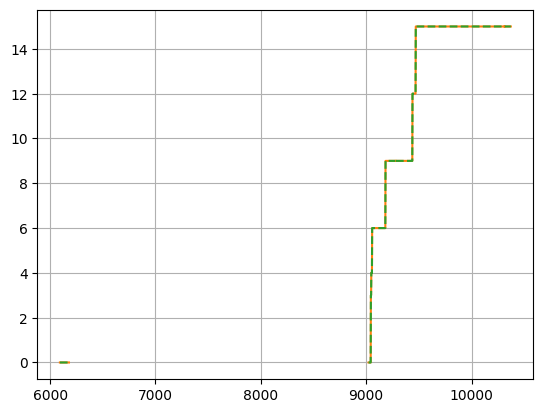

In [7]:
case_data["Orchestra/PPF20_CT"].plot()
case_data["Orchestra/NEPI_RATE"].plot()
case_data["Orchestra/NEPI_RATE"].fillna(method='ffill')
case_data["Orchestra/NEPI_RATE"].plot(style='--')
plt.grid()

<AxesSubplot:>

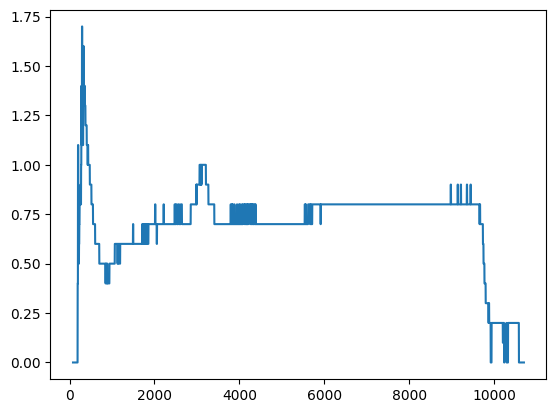

In [8]:
case_data["Primus/MAC"].ffill().plot(style='-')

In [9]:
'a' in 'abc'

True